In [84]:
from datasets import load_dataset
import numpy as np
import torch 
from tqdm.auto import tqdm
from torch.optim import AdamW

dataset = load_dataset("emotion", cache_dir="./data")
train_data = dataset["train"]
test_data = dataset["test"]
seed = 10

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [73]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_test = test_data.map(tokenize_function, batched=True)

In [74]:
mini_train = tokenized_train.shuffle(seed=seed).select(range(1000))
mini_test = tokenized_test.shuffle(seed=seed).select(range(100))

In [75]:
from torch.utils.data import DataLoader
import torch

def collate_fn(batch):
    return {
        'input_ids': torch.tensor([item['input_ids'] for item in batch]),
        'attention_mask': torch.tensor([item['attention_mask'] for item in batch]),
        'labels': torch.tensor([item['label'] for item in batch])
    }

train_dataloader = DataLoader(tokenized_train, shuffle=True, batch_size=8, collate_fn=collate_fn)
test_dataloader = DataLoader(tokenized_test, batch_size=8, collate_fn=collate_fn)

mini_test_dataloader = DataLoader(mini_test, batch_size=8, shuffle=True, collate_fn=collate_fn)
mini_train_dataloader = DataLoader(mini_train, batch_size=8, collate_fn=collate_fn)


In [76]:
from transformers import BertForSequenceClassification

num_labels = len(train_data.features["label"].names)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
def evaluate_acc(y_hat: np.ndarray, y: np.ndarray):
    print(y_hat.shape, y.shape)
    return np.sum(y_hat == y) / y.size

In [78]:
def encode_y(y: np.ndarray):
    y = y.reshape(-1, 1)
    y_encoded = np.zeros((len(y), num_labels))
    for i in range(num_labels):
        y_encoded[:, i] = (y == i).reshape(-1)
    return y_encoded

In [79]:
def compute_F1(y_hat, y):
    y_encoded = encode_y(y)
    y_hat_encoded = encode_y(y_hat)
    J = np.zeros((y_encoded.shape[1], 1))
    P = np.zeros((y_encoded.shape[1], 1)) # Precision
    R = np.zeros((y_encoded.shape[1], 1)) # Recall
    for i in range(y_encoded.shape[1]):
        y_column = y_encoded[:, i]
        y_hat_column = y_hat_encoded[:, i]
        y_true = y_column == 1
        y_hat_true = y_hat_column==1
        true_positives = np.sum((y_true==1) & (y_hat_true==1))
        false_positives = np.sum((y_true==0) & (y_hat_true==1))
        false_negatives = np.sum((y_true==1) & (y_hat_true==0))
        epsilon = 1e-8
        precision = float(true_positives) / float(true_positives + false_positives + epsilon)
        recall = float(true_positives) / float(true_positives + false_negatives + epsilon)
        F1 = (2 * precision * recall) / (precision + recall + epsilon)
        J[i] = F1
        P[i] = precision
        R[i] = recall
    return J, P, R

In [80]:
# with torch.no_grad():
#         y_true = []
#         y_pred = []
#         for batch in tqdm(test_dataloader):
#             batch = {k: v.to(device) for k, v in batch.items()}
#             outputs = model(**batch)
#             logits = outputs.logits
#             y_true.extend(batch["labels"].cpu().numpy())
#             y_pred.extend(torch.argmax(logits, axis=-1).cpu().numpy())
#         print(f"Accuracy: {accuracy_score(y_true, y_pred)}, F1: {f1_score(y_true, y_pred, average='macro')}")

def test_model(current_model, current_dataloader):
    current_model.to(device)
    current_model.eval()
    y_true = []
    y_hat = []
    with torch.no_grad():
        for batch in tqdm(current_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = current_model(**batch)
            logits = outputs.logits
            yh = logits.argmax(dim=1).cpu().numpy()
            yh = yh.tolist()
            y_hat.extend(yh)
            y_val = batch["labels"].cpu().numpy()
            y_val = y_val.tolist()
            y_true.extend(y_val)
    y_hat = np.array(y_hat)
    y_true = np.array(y_true)
    acc = evaluate_acc(y_hat, y_true)
    J, P, R = compute_F1(y_hat, y_true)
    return acc, J, P, R

In [81]:
# Create untrained copy of model
model_untrained = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels).to(device)
acc, f1, precision, recall = test_model(model_untrained, test_dataloader)

print(f"Untrained model accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 250/250 [02:12<00:00,  1.89it/s]

(2000,) (2000,)
Untrained model accuracy: 0.1025, F1: [[0.04234528]
 [0.01420455]
 [0.06434316]
 [0.        ]
 [0.18415417]
 [0.03614457]], Precision: [[0.39393939]
 [0.55555555]
 [0.05607477]
 [0.        ]
 [0.10462287]
 [0.03      ]], Recall: [[0.02237522]
 [0.00719424]
 [0.0754717 ]
 [0.        ]
 [0.76785714]
 [0.04545455]]


In [82]:
initial_acc = acc
initial_f1 = f1
initial_precision = precision
initial_recall = recall

In [38]:

from sklearn.metrics import accuracy_score, f1_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):  # number of epochs
    torch.cuda.empty_cache()
    model.train()
    for batch in tqdm(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for batch in tqdm(test_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            y_true.extend(batch["labels"].cpu().numpy())
            y_pred.extend(torch.argmax(logits, axis=-1).cpu().numpy())
        print(f"Epoch {epoch}: Accuracy: {accuracy_score(y_true, y_pred)}, F1: {f1_score(y_true, y_pred, average='macro')}")

  0%|          | 0/2000 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'to'

In [83]:
acc_list = initial_acc
f1_list = initial_f1
precision_list = initial_precision
recall_list = initial_recall

In [85]:
def fit(fit_model, fit_dataloader, optimizer, epochs=3):
    torch.cuda.empty_cache()
    fit_model.to(device)
    for epoch in range(epochs):  # number of epochs
        fit_model.train()
        for batch in tqdm(fit_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = fit_model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        acc, f1, precision, recall = test_model(fit_model, test_dataloader)
        acc_list.append(acc)
        f1_list.append(f1)
        precision_list.append(precision)
        recall_list.append(recall)
        print(f"Epoch {epoch}: Accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")

In [86]:
optimizer = AdamW(model.parameters(), lr=5e-5)
fit(model, mini_train_dataloader, optimizer, epochs=3)

  4%|▍         | 5/125 [00:59<23:54, 11.96s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model.pt')


In [ ]:
# Test saved model
model_saved = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model_saved.load_state_dict(torch.load('model.pt'))

model_saved.eval()

with torch.no_grad():
        y_true = []
        y_pred = []
        for batch in tqdm(test_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            y_true.extend(batch["labels"].cpu().numpy())
            y_pred.extend(torch.argmax(logits, axis=-1).cpu().numpy())
        print(f"Accuracy: {accuracy_score(y_true, y_pred)}, F1: {f1_score(y_true, y_pred, average='macro')}")



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/250 [00:00<?, ?it/s]

Accuracy: 0.93, F1: 0.8885919885459281


In [87]:
def kaiming(module):
    if isinstance(module, (torch.nn.Linear, torch.nn.Embedding)):
        torch.nn.init.kaiming_normal_(module.weight.data, nonlinearity='relu')


In [ ]:
config = model.config
config.num_hidden_layers = 8 # Default was 12
config.num_attention_heads = 8 # Default was 12
#Load pre-trained model with new config
model_new = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model_new.to(device)
with torch.no_grad():
        y_true = []
        y_pred = []
        for batch in tqdm(test_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model_new(**batch)
            logits = outputs.logits
            y_true.extend(batch["labels"].cpu().numpy())
            y_pred.extend(torch.argmax(logits, axis=-1).cpu().numpy())
        print(f"Accuracy: {accuracy_score(y_true, y_pred)}, F1: {f1_score(y_true, y_pred, average='macro')}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/250 [00:00<?, ?it/s]

Accuracy: 0.136, F1: 0.04024263944370469


In [ ]:
optimizer = AdamW(model_new.parameters(), lr=5e-5)
loss_list = []
for epoch in range(3):  # number of epochs
    torch.cuda.empty_cache()
    model_new.train()
    for batch in tqdm(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_new(**batch)
        loss = outputs.loss
        loss_list.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    model_new.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for batch in tqdm(test_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model_new(**batch)
            logits = outputs.logits
            y_true.extend(batch["labels"].cpu().numpy())
            y_pred.extend(torch.argmax(logits, axis=-1).cpu().numpy())
        print(f"Epoch {epoch}: Accuracy: {accuracy_score(y_true, y_pred)}, F1: {f1_score(y_true, y_pred, average='macro')}")

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 0: Accuracy: 0.9285, F1: 0.8742280120148399


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: Accuracy: 0.9055, F1: 0.8542145800058306


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2: Accuracy: 0.9225, F1: 0.8786378486973314


In [ ]:
# Save model
torch.save(model_new.state_dict(), 'model_new.pt')

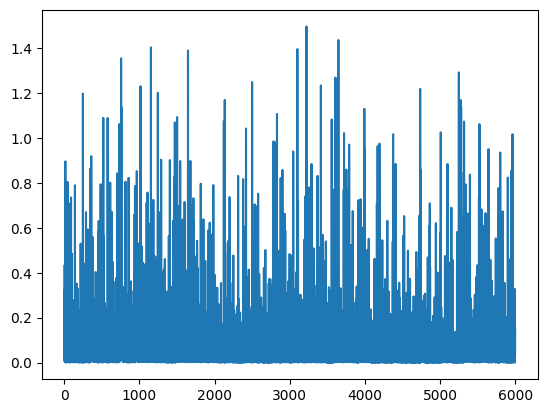

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
loss_list_np = []
for loss in loss_list:
  loss_list_np.append(loss.item())

loss_list_np = np.array(loss_list_np)
plt.plot(loss_list_np)
plt.show()
